## BASE MODEL - Z-Score

Implemented a dynamic Z-score pairs trading strategy on the BankNifty–Nifty spread, using volatility-adjusted entry and exit thresholds. Generated positions based on rolling mean and standard deviation of the spread, scaled by dynamic windows reflecting changing volatility. Calculated strategy PnL, cumulative returns, and evaluated performance metrics. The strategy achieved an absolute return of 61,464, annualized Sharpe of 5.17, maximum drawdown of -7,621 (-11.8%), with a win rate of 64.8% across 4,368 trades, demonstrating effective mean-reversion capture under varying volatility conditions.

Imported necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (12,7)})

DATA_PATH = '/content/drive/MyDrive/Quant_project/data.parquet'


Loaded the dataset from the parquet file, converted the time column to datetime index,
ensured numeric types for key columns, sorted by time, and filled any missing values.

In [2]:
raw = pd.read_parquet(DATA_PATH)

if 'time' in raw.columns and not isinstance(raw.index, pd.DatetimeIndex):
    raw.index = pd.to_datetime(raw['time'])
    raw = raw.drop(columns=['time'])
else:
    raw.index = pd.to_datetime(raw.index)

raw = raw.sort_index()
for col in ['banknifty','nifty','tte']:
    raw[col] = pd.to_numeric(raw[col], errors='coerce').astype('float32')

df = raw.ffill().bfill()
print("Rows:", len(df))
display(df.head(3))


Rows: 690512


,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27.0
2021-01-01 09:16:00,0.285381,0.200432,27.0
2021-01-01 09:17:00,0.284233,0.200004,27.0


Calculated the spread between BankNifty and Nifty, created a shaped pnL metric, and displayed basic descriptive statistics for both series

In [3]:
df['spread'] = df['banknifty'] - df['nifty']
df['pnl'] = df['spread'] * (df['tte'] ** 0.7)

print("Spread & PnL sample stats:")
display(df[['spread','pnl']].describe().T)


Spread & PnL sample stats:


,count,mean,std,min,25%,50%,75%,max
spread,690512.0,0.070810,0.026192,-0.007531,0.053297,0.066501,0.082271,0.209055
pnl,690512.0,0.462385,0.263375,-0.016249,0.259512,0.420834,0.614037,2.313208


Computed 60-minute rolling volatility of the spread and plotted it to visualize short-term fluctuations.

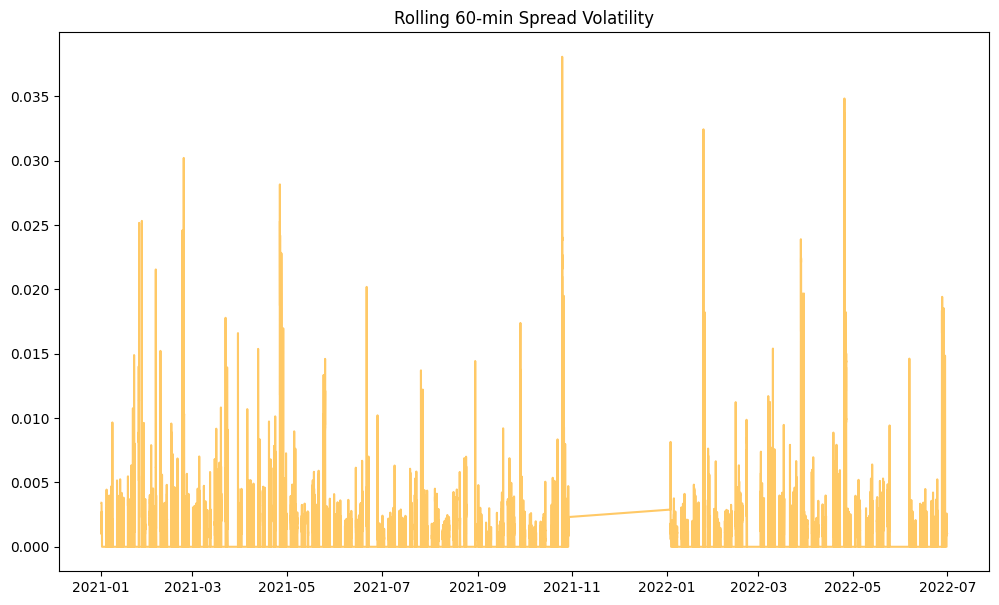

In [4]:
df['spread_vol'] = df['spread'].rolling(60).std().ffill().bfill()
plt.plot(df['spread_vol'], color='orange', alpha=0.6)
plt.title('Rolling 60-min Spread Volatility')
plt.show()


Created a dynamic lookback window based on spread volatility, scaling between minimum and maximum values to adapt strategy sensitivity.

In [5]:
def dynamic_window(vol, min_win=50, max_win=120):
    vol_filled = vol.fillna(0)
    vol_scaled = (vol_filled - vol_filled.min()) / (vol_filled.max() - vol_filled.min() + 1e-8)
    dyn_win = max_win - (max_win - min_win) * vol_scaled
    return dyn_win.clip(lower=min_win).round().astype(int)

df['dyn_window'] = dynamic_window(df['spread_vol'])
print("Dynamic window stats:")
display(df['dyn_window'].describe())


Dynamic window stats:


,dyn_window
count,690512.000000
mean,119.015497
std,3.638844
min,50.000000
25%,120.000000
50%,120.000000
75%,120.000000
max,120.000000


Calculated dynamic Z-score entry and exit thresholds based on current spread volatility to adjust trading signals adaptively

In [6]:
def dynamic_zscores(vol, entry_base=1.7, exit_base=0.4):
    vol_filled = vol.fillna(0)
    vol_scaled = (vol_filled - vol_filled.min()) / (vol_filled.max() - vol_filled.min() + 1e-8)
    entry_dynamic = entry_base + 0.5 * vol_scaled
    exit_dynamic = exit_base + 0.25 * (1 - vol_scaled)
    return entry_dynamic, exit_dynamic

df['entry_z'], df['exit_z'] = dynamic_zscores(df['spread_vol'])
print("Dynamic entry/exit Z thresholds sample:")
display(df[['entry_z','exit_z']].head(5))


Dynamic entry/exit Z thresholds sample:


,entry_z,exit_z
time,,
2021-01-01 09:15:00,1.744945,0.627527
2021-01-01 09:16:00,1.744945,0.627527
2021-01-01 09:17:00,1.744945,0.627527
2021-01-01 09:18:00,1.744945,0.627527
2021-01-01 09:19:00,1.744945,0.627527


Generated trading positions using dynamic Z-score strategy, adapting to recent spread behavior and volatility-adjusted entry/exit thresholds.

In [7]:
positions = np.zeros(len(df))

for i in tqdm(range(len(df)), desc='Generating positions'):
    if i < 1: continue
    window = df['dyn_window'].iloc[i]
    spread_mean = df['spread'].iloc[max(0,i-window):i].mean()
    spread_std = df['spread'].iloc[max(0,i-window):i].std()
    zscore = (df['spread'].iloc[i] - spread_mean) / (spread_std + 1e-8)

    pos = positions[i-1]
    entry_z = df['entry_z'].iloc[i]
    exit_z = df['exit_z'].iloc[i]

    if pos == 0:
        if zscore > entry_z:
            pos = -1
        elif zscore < -entry_z:
            pos = 1
    elif pos == 1 and zscore >= exit_z:
        pos = 0
    elif pos == -1 and zscore <= -exit_z:
        pos = 0

    positions[i] = pos

df['position'] = positions
print("Positions generated. Sample:")
display(df[['spread','position']].head(10))


Generating positions: 100%|██████████| 690512/690512 [03:16<00:00, 3506.70it/s]

Positions generated. Sample:


,spread,position
time,,
2021-01-01 09:15:00,0.086329,0.0
2021-01-01 09:16:00,0.084948,0.0
2021-01-01 09:17:00,0.084229,0.0
2021-01-01 09:18:00,0.086243,0.0
2021-01-01 09:19:00,0.086588,0.0
2021-01-01 09:20:00,0.084715,0.0
2021-01-01 09:21:00,0.083683,1.0
2021-01-01 09:22:00,0.085146,1.0
2021-01-01 09:23:00,0.083308,1.0


Calculated strategy PnLby combining positions with spread PnL scaledby volatility and visulaized cumulative performance over time

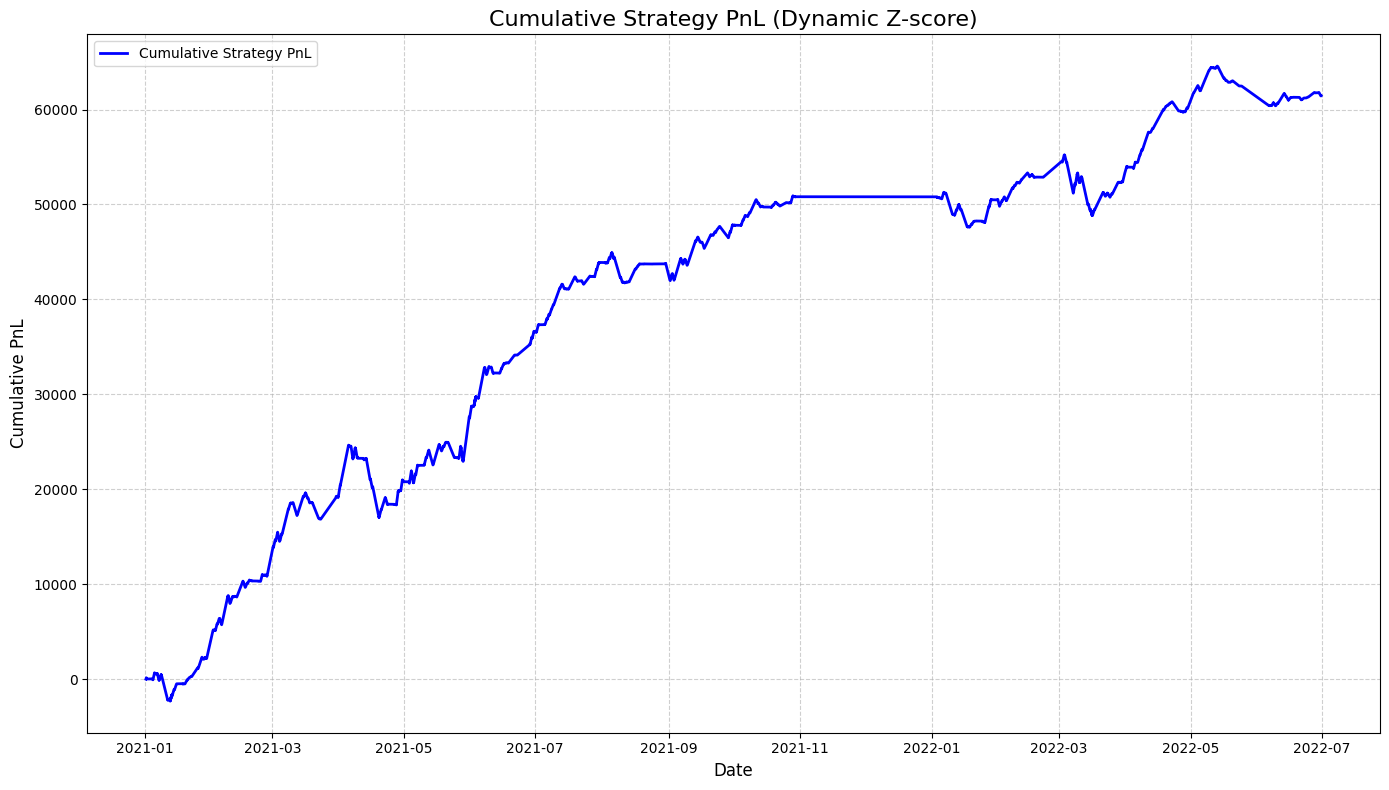

In [9]:
vol_scale = (df['spread_vol'].max() - df['spread_vol']) / df['spread_vol'].max()
df['strategy_pnl'] = df['position'].shift().fillna(0) * df['pnl'] * vol_scale
df['cum_pnl'] = df['strategy_pnl'].cumsum()

plt.style.use('default')
plt.figure(figsize=(14,8))
plt.plot(df.index, df['cum_pnl'], color='blue', label='Cumulative Strategy PnL', linewidth=2)
plt.title('Cumulative Strategy PnL (Dynamic Z-score)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative PnL', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Calculated strategy performance metrics including total return, Sharpe ratio, maximum drawdown, win rate, and number of trades

In [10]:
daily_pnl = df['strategy_pnl'].resample('D').sum()
daily_pnl = daily_pnl[daily_pnl != 0]

absolute_return = df['cum_pnl'].iloc[-1]
sharpe_ratio = daily_pnl.mean() / daily_pnl.std() * np.sqrt(252) if daily_pnl.std()>0 else 0
rolling_max = df['cum_pnl'].cummax()
drawdown = df['cum_pnl'] - rolling_max
max_drawdown = drawdown.min()
max_drawdown_pct = (max_drawdown / rolling_max.max())*100 if rolling_max.max()!=0 else np.nan
trade_pnls = df['strategy_pnl'][df['strategy_pnl']!=0]
wins = (trade_pnls>0).sum()
losses = (trade_pnls<0).sum()
win_rate = wins / (wins+losses) if (wins+losses)>0 else np.nan
trade_count = (df['position'].diff().abs() > 0).sum()

metrics = {
    'Absolute Return': absolute_return,
    'Annualized Sharpe Ratio': sharpe_ratio,
    'Max Drawdown': max_drawdown,
    'Max Drawdown %': max_drawdown_pct,
    'Win Rate': win_rate,
    'Trade Count': trade_count
}

display(pd.DataFrame.from_dict(metrics, orient='index', columns=['Value']))


,Value
Absolute Return,61464.068560
Annualized Sharpe Ratio,5.165937
Max Drawdown,-7621.130266
Max Drawdown %,-11.802063
Win Rate,0.648505
Trade Count,4368.000000
